In [1]:
import sys
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#The following line makes modules in src/ accessible from the (current) test/ dir
sys.path.append("../src")
import nevh

In [2]:
# Hamiltonian (Cartesian coordinates)
def H(t, s, GM, m):
    x, y, px, py = s
    V = -GM * m / (np.sqrt(x**2 + y**2))
    T = 1/(2 * m) * (px**2 + py**2)
    return T + V

In [3]:
# MLT units: solar mass, AU, year
GM = 39.4905
m = 3.0034E-6

# Initial position and momentum for Earth-like circular orbit
x0 = 1.0; y0 = 0.0
r0=(x0**2+y0**2)**0.5
p0x = 0.0; p0y = m * (GM / r0)**0.5

# Time domain for the integration
tmin = 0.0; tmax = 1.0;
t = np.linspace(tmin, tmax, 12, endpoint=False)

# Initial state
s0 = np.array ([x0, y0, p0x, p0y]) 

In [5]:
# Discretization steps
ds = np.ones(4)*1e-4

# Create objet that computes rh sides of Hamilton eqs
G = nevh.HGrad(H, ds, GM=GM, m=m)

# Solve the ODE system
%time trj = solve_ivp(G, [tmin, tmax], s0, t_eval=t, rtol=1e-6)

CPU times: user 15.6 ms, sys: 2.57 ms, total: 18.2 ms
Wall time: 19.1 ms


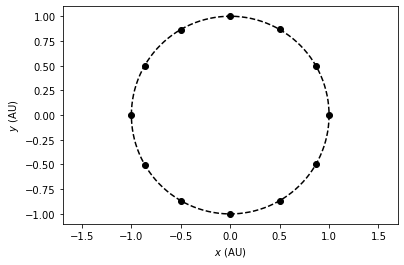

In [6]:
x,y = trj.y[:2]

# Analytic solution orbit
alpha = GM * m
l = x0 * p0y - y0  * p0x
E =(p0x**2+p0y**2) / (2*m) - alpha / r0
c1 = l**2 / (m*alpha)
c2 = (1 + 2*E*l**2/(m*alpha**2))**0.5
theta = np.linspace(0, 2*np.pi, 360)
xan = -c1 * np.cos(theta) / (1 + c2*np.cos(theta))
yan = c1 * np.sin(theta) / (1 + c2*np.cos(theta))

plt.axis('equal')
plt.xlabel('$x$ (AU)')
plt.ylabel('$y$ (AU)')
plt.plot(x, y,'ko', xan, yan, 'k--');
plt.savefig('orbit.png')

In [7]:
# Error estimative (only for circular orbits)
w = p0y / (m * r0)
xt = np.array([r0*np.cos(w*t)])
yt = np.array([r0*np.sin(w*t)])
err = (((x-xt)**2 + (y-yt)**2)**0.5).sum()/len(t)
print("e =",err)

e = 6.332104495733903e-05


In [8]:
# Explicit partial derivatives
def G(t, s, GM, m):
    x, y, px, py = s
    r3 = (x**2 + y**2)**1.5
    dHdx  = px/m
    dHdy  = py/m
    dHdpx = GM * m * x / r3
    dHdpy = GM * m * y / r3
    return[dHdx, dHdy, -dHdpx, -dHdpy]

In [9]:
%time T = solve_ivp(G,[tmin, tmax], s0, args=[GM, m],method='DOP853',max_step=(tmax-tmin)/96)

CPU times: user 17.4 ms, sys: 5.62 ms, total: 23.1 ms
Wall time: 19.5 ms


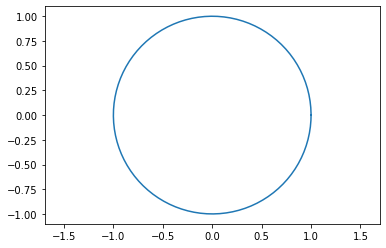

In [10]:
t=T.t
x=T.y[0]
y=T.y[1]
plt.axis('equal')
plt.plot(x,y);